# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

The following is an examination of a set of job postings with their indicated salaries. Given this historical data and hiring trend, Human Resources would want to predict an employee's salary based on factors such as years of experience, job type, educational background, industry, and distance from metropolis 

In [1]:
__author__ = "Jose Martinez"
__email__ = "jmart368@gmail.com"

In [2]:
#import libraries
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [3]:
# load the data into a Pandas dataframe
test_features_df = pd.read_csv('test_features.csv')
train_features_df = pd.read_csv('train_features.csv')
train_salaries_df = pd.read_csv('train_salaries.csv')

In [4]:
# examine the 3 dataframes
test_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [5]:
# check for null values
test_features_df.isnull().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64

In [6]:
train_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [7]:
train_features_df.isnull().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64

In [8]:
train_salaries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   jobId   1000000 non-null  object
 1   salary  1000000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [9]:
train_salaries_df.isnull().sum()

jobId     0
salary    0
dtype: int64

After confirming that no null values exist, we can therefore merge the train features and train salaries into one new dataframe which we can refer to as train_data_df.

In [10]:
# merge test and train features on job id
train_data = pd.merge(train_features_df, train_salaries_df, on = 'jobId')
# check for null after merging 
train_data.isnull().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

### ---- 3 Clean the data ----

In [11]:
# data dimensions
train_data.shape

(1000000, 9)

When we look at the dimensions of our data we can conclude that there are 1,000,000 rows representing the job profiles and 9 columns representing numerical/categorical data.

In [12]:
# look for duplicate data
train_data.duplicated().sum()

0

In [13]:
# search for invalid data (e.g. salaries <=0)
train_data[train_data['salary'] <= 0]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


When factoring the salaries where the salary <= 0, we can note that only 5 results rendered a 0 value.

Since these 5 results are immaterial in comparison to 1,000,000 job profiles, it would be easier to drop these rows rather than guess the missing salaries. Guessing mean salaries would hinder the quality of our data set. Using a Mean or Median value as replacement would also overinflate the salary of a Junior level candidate as well as underinflate the salary of a Manager or VP.

In [14]:
train_data[["jobType", "salary"]].groupby("jobType").describe()

salary                                                     \
                   count        mean        std   min    25%    50%     75%   
jobType                                                                       
CEO             124778.0  145.311425  34.423846  55.0  120.0  142.0  167.00   
CFO             124369.0  135.458547  33.069203  51.0  111.0  132.0  156.00   
CTO             125046.0  135.479983  33.093032   0.0  111.0  132.0  156.00   
JANITOR         124971.0   70.813045  24.643021  17.0   52.0   68.0   86.00   
JUNIOR          124594.0   95.331557  29.249018   0.0   74.0   92.0  113.75   
MANAGER         125121.0  115.367596  30.835467   0.0   93.0  112.0  135.00   
SENIOR          125886.0  105.487775  30.069722  31.0   83.0  102.0  124.00   
VICE_PRESIDENT  125235.0  125.367629  31.958131   0.0  102.0  122.0  146.00   

                       
                  max  
jobType                
CEO             298.0  
CFO             301.0  
CTO             301.0  
JANITOR         189.0  
JUNIOR          248.0  
MANAGER         270.0  
SENIOR          258.0  
VICE_PRESIDENT  272.0

In [15]:
# drop missing data where salary is 0
train_data = train_data.loc[train_data['salary'] != 0]

In [16]:
# confirm that 0 salary values were dropped
print(train_data.shape)
print(train_data[train_data['salary'] <= 0])

(999995, 9)
Empty DataFrame
Columns: [jobId, companyId, jobType, degree, major, industry, yearsExperience, milesFromMetropolis, salary]
Index: []


### ---- 4 Explore the data (EDA) ----

In [17]:
# summarize numerical values 
train_data.describe(include = [np.number])

,yearsExperience,milesFromMetropolis,salary
count,999995.000000,999995.000000,999995.000000
mean,11.992407,49.529381,116.062398
std,7.212390,28.877721,38.717163
min,0.000000,0.000000,17.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


In [18]:
# summarize categorical values
train_data.describe(include = ['object'])

,jobId,companyId,jobType,degree,major,industry
count,999995,999995,999995,999995,999995,999995
unique,999995,63,8,5,9,7
top,JOB1362685188811,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236975,532353,143205


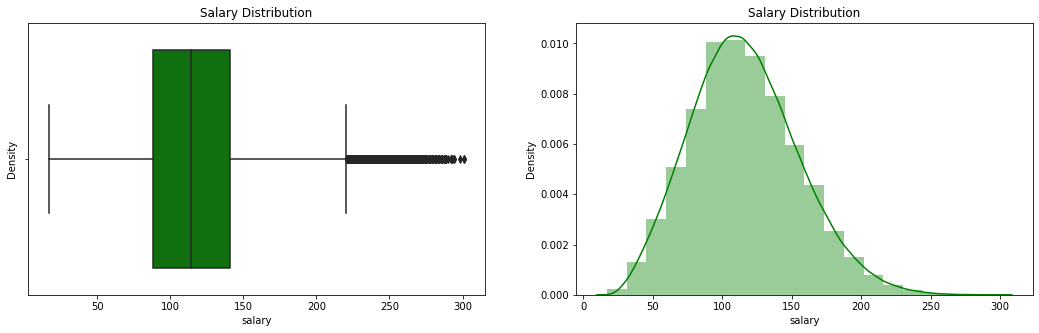

In [19]:
# Summarize the target variable - Salary
plt.figure(figsize = (18,5))
plt.subplot(1,2,1)
sns.boxplot(train_data.salary, color="Green")
plt.title("Salary Distribution")
plt.ylabel('Density')
plt.subplot(1,2,2)
sns.distplot(train_data.salary, bins=20, color="Green")
plt.title('Salary Distribution')
plt.show()

Based on the Salary Distribution plots, we can see that the target variable is normally distributed with a right skewness due to some outliers beyond the $220 range. We can further confirm with the use of our outlier check function we do have some outliers whilet extracting the upper and lower range.

In [20]:
def outlier_check(dfcol):
    """
    Function to extract IQR
    """
    sorted(dfcol)
    Q1, Q3 = np.percentile(dfcol , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return upper_range, lower_range

upper_range, lower_range = outlier_check(train_data['salary'])

print(f"The upper and lower salary are ${upper_range} and ${lower_range}.")

The upper and lower salary are $220.5 and $8.5.


In [21]:
def plot_features(df, col):
    """
    Function to plot each feature with the target variable
    """
    plt.figure (figsize = (16,8))
    plt.subplot(1,2,1)
    if df[col].dtype == 'int64' or col =='companyId':
        mean = df.groupby(col)['salary'].mean()
        std = df.groupby(col)['salary'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values+std.values, \
                        alpha =0.1)
        plt.ylabel('Salaries')
    else :
        col_mean = df.groupby(col)['salary'].mean()
        df[col] = df[col].astype('category')
        levels = col_mean.sort_values().index.tolist()
        df[col].cat.reorder_categories(levels, inplace=True)
        col_mean.sort_values().plot(kind='bar')
        plt.xticks(rotation=45)
        plt.xlabel(col)
        plt.ylabel('Averge salary by'+ ' ' + col)
        plt.subplot(1,2,2)
        sns.boxplot(x=col, y='salary', data=df)
        plt.xticks(rotation=45)    
        plt.ylabel('Salaries')
    plt.show()

In [22]:
train_data_feat=['jobType', 'degree', 'major', 'industry', 'yearsExperience','milesFromMetropolis']
train_data_cat=['jobType', 'degree', 'major', 'industry'] 
train_data_numfeat=[]

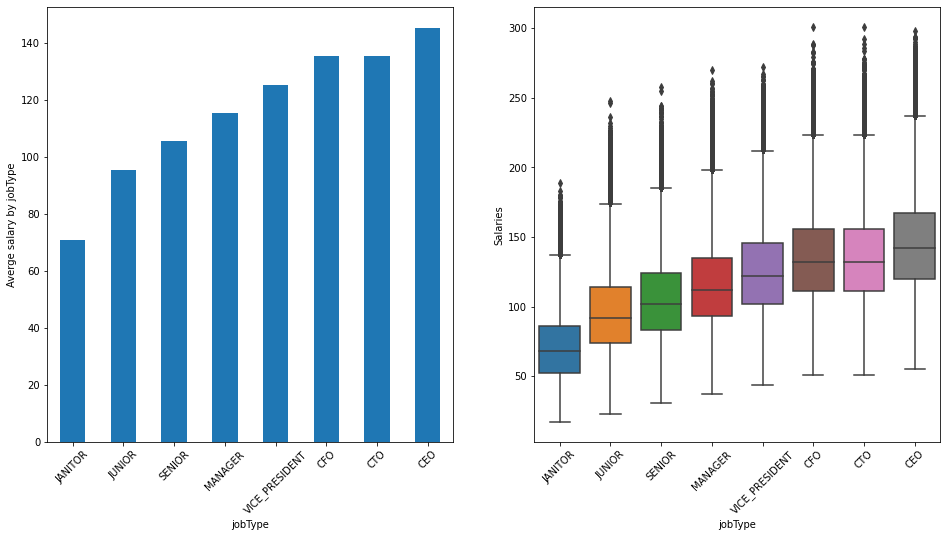

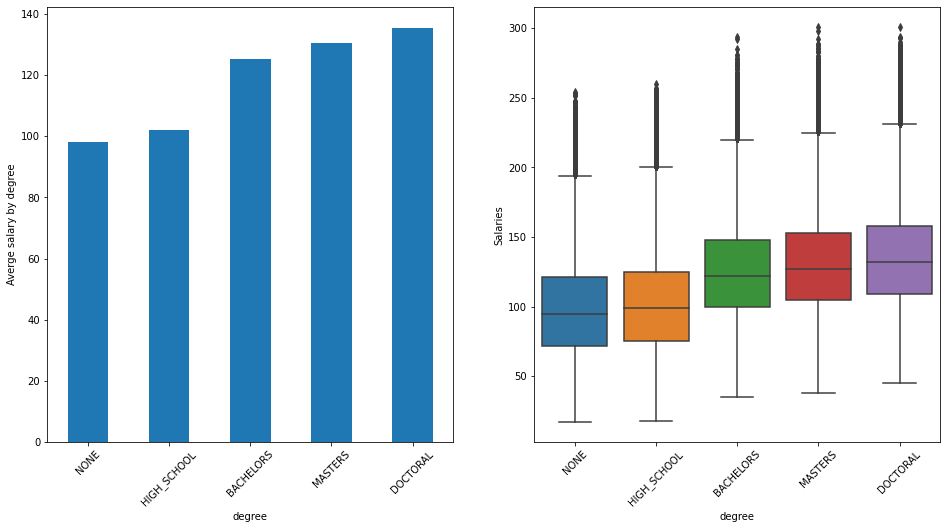

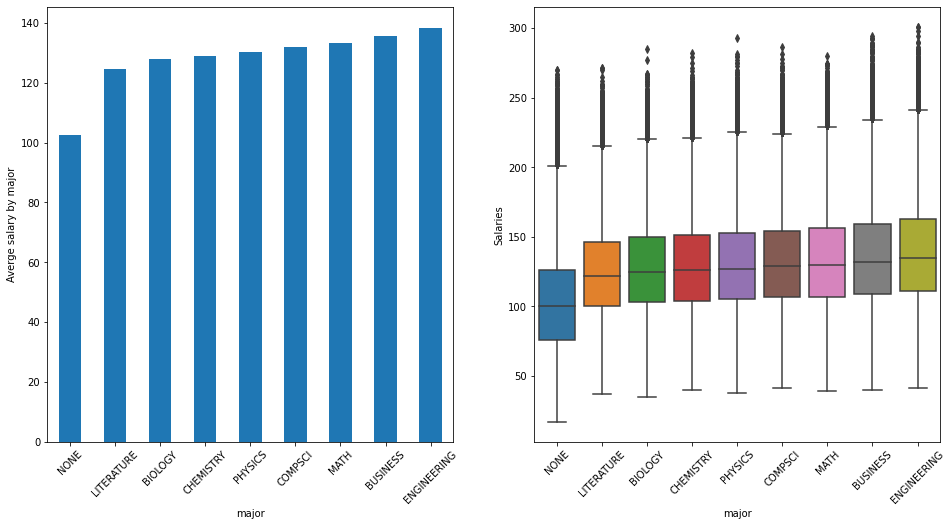

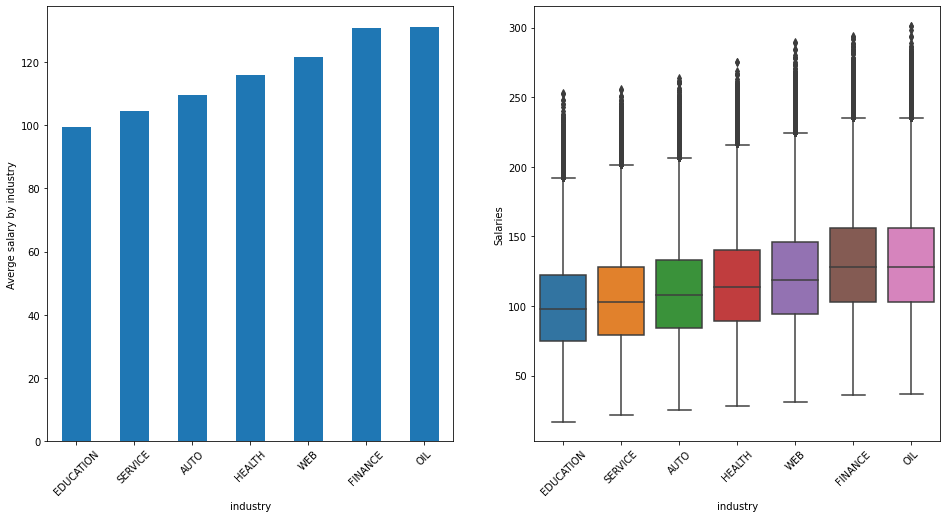

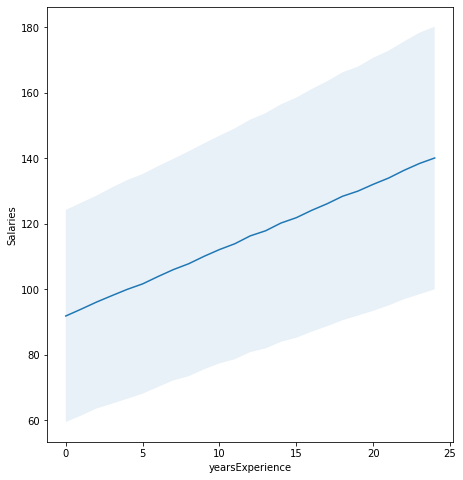

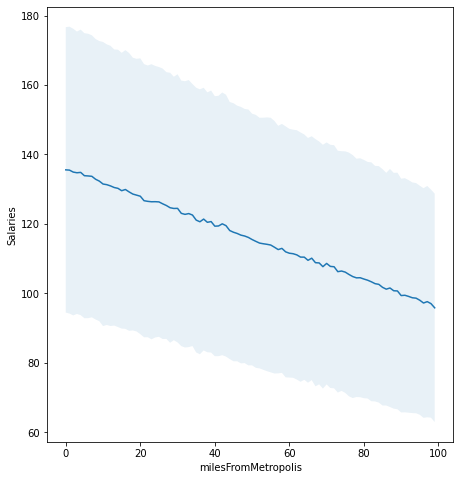

In [23]:
for features in train_data_feat:
    plot_features(train_data, features)

A couple of observations to note from the above:
* When we look at average salary by job type, c-suite postions end up making the most in salary.
* Those who have at least bachelors degree or higher, tend to have a higher than average salary.
* Business and Engineering majors tend to make more in average salaries in comparison toother majors.
* The Finance and Oil Industry have higher average salaries than Education, Service, Auto, Health, and Web.
* There is a postive correlation with having a higher salary and more years of experience.
* There is a negative correlation with having a higher salary and living further way from a major city.

In [24]:
def label_encode(df, col):
    """
    Function to convert each categorical variable by replacing and 
    using the average salary of that category
    """
    dict = {}
    cat_list = df[col].cat.categories.tolist()
    for cat in cat_list:
        dict[cat] = train_data[train_data[col] == cat]['salary'].mean()
    df[col] = train_data[col].map(dict)

In [25]:
train_copy = train_data.copy()
for col in train_copy.columns:
    if train_copy[col].dtype.name == 'category':
        label_encode(train_copy, col)
        train_copy[col] = train_copy[col].astype('float')

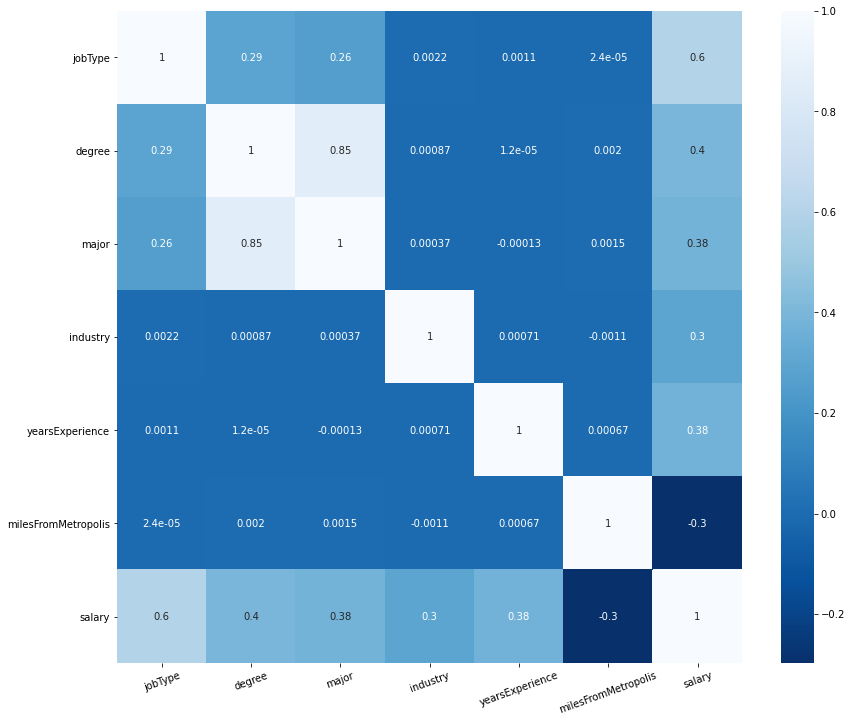

In [26]:
# create a correlation matrix to show the relationships between each variable
corr_matrix = train_copy.corr()
plt.figure(figsize=(14,12))
sns.heatmap(corr_matrix, annot=True, cmap='Blues_r')
plt.xticks(rotation=20)
plt.yticks(rotation=0)
plt.show()

Based on the above correlation matrix we can note that there is a negative correlation with the following variables,
* salary and milesFromMetropolis
* industry and milesFromMetropolis
* yearsExperience and major

All other variables are positively correlated with degree and major having the strongest correlation.

### ---- 5 Establish a baseline ----

In [27]:
# select a reasonable metric (MSE in this case)
# create an extremely simple model and measure its efficacy
# e.g. use "average salary" for each industry as your model and then measure MSE
# during 5-fold cross-validation

In [28]:
mse = mean_squared_error(train_copy['industry'], train_copy['salary'])
print(f'The baseline model Mean Squared Error is: {mse}')

The baseline model Mean Squared Error is: 1367.122950785255


### ---- 6 Hypothesize solution ----

Brainstorm 3 models that you think may improve results over the baseline model based

**Linear Regression:** Basic regression model which can be used for any data set and size. It is also a straighforward model used for prediction.

**Random Forest:** A low bias model that is very fast and powerful to solve regression and classficiation problems. 

**Gradient Boosting:** A fast and high performanced based model that can create simple individual models by combining them into a new one.

## Part 3 - DEVELOP

### ---- 7 Engineer features  ----

In [29]:
# create any new features needed to potentially enhance model
cat_variables = ['jobType', 'degree', 'major', 'industry'] 
num_variables = ['yearsExperience', 'milesFromMetropolis', 'salary']
feat_variables = ['jobType', 'degree', 'major', 'industry', 'yearsExperience', 'milesFromMetropolis']

In [30]:
dummy_features_train = pd.get_dummies(train_data[cat_variables], drop_first=True)
train_df = pd.concat([dummy_features_train, train_data[num_variables]], axis=1)
train_df.head(5)

,jobType_JUNIOR,jobType_SENIOR,jobType_MANAGER,jobType_VICE_PRESIDENT,jobType_CFO,jobType_CTO,jobType_CEO,degree_HIGH_SCHOOL,degree_BACHELORS,degree_MASTERS,...,major_ENGINEERING,industry_SERVICE,industry_AUTO,industry_HEALTH,industry_WEB,industry_FINANCE,industry_OIL,yearsExperience,milesFromMetropolis,salary
0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,10,83,130
1,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,1,0,0,3,73,101
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,10,38,137
3,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,8,17,142
4,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,8,16,163


In [31]:
# split the data into train and test sets with test size at 30%
X_train, X_test, Y_train, Y_test = train_test_split(train_df.iloc[:,:-1], train_df.salary, test_size=0.3)

In [32]:
# confirm and observe the split
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(699996, 27)
(299999, 27)
(699996,)
(299999,)


### ---- 8 Create models ----

In [33]:
# create and tune the models that you brainstormed during part 2

**8.1 Linear Regression**

In [34]:
lr = LinearRegression()
lr.fit(X_train, Y_train)

LinearRegression()

**8.2 Random Forest**

In [35]:
rf = RandomForestRegressor(n_estimators=150,max_depth=25, max_features=25, random_state=0, min_samples_split=60)

**8.3 Gradient Boosting Regressor**

In [36]:
gr = GradientBoostingRegressor(n_estimators=160, max_depth=6, loss='ls', verbose=0 )

### ---- 9 Test models ----

**9.1 Linear Regression Test**

In [37]:
lr_score = lr.predict(X_test)
lr_mse = mean_squared_error(Y_test, lr_score) # calculate the mean square error of the linear model
lr_mse

384.6718010727318

**9.2 Random Forest Test**

In [38]:
rf_score = cross_val_score(rf, X_test, Y_test, cv=5, scoring="neg_mean_squared_error") 
rf_mse = -1.0 * np.mean(rf_score)
rf_mse

382.9133917274446

**9.3 Gradient Boosting Regressor**

In [39]:
gb_score = cross_val_score(gr, X_test, Y_test, cv=5, scoring="neg_mean_squared_error")
gb_mse = -1.0 * np.mean(gb_score)
gb_mse 

360.5106005885759

### ---- 10 Select best model  ----

In [40]:
# select the model with the lowest error as your "production" model
models_MSE =pd.DataFrame(({'Models':['Linear regression','Random Forest','Gradient Boosting Regressor'],
               'Mean Squared Error':[lr_mse,rf_mse,gb_mse]}))
models_MSE

,Models,Mean Squared Error
0,Linear regression,384.671801
1,Random Forest,382.913392
2,Gradient Boosting Regressor,360.510601


Based on the lowest MSE, the best model is Gradient Boosting Regressor

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [41]:
# write script that trains model on entire training set, saves model to disk,
num_variables.remove('salary')

In [42]:
dummy_features_test = pd.get_dummies(test_features_df[cat_variables], drop_first=True)
test_df = pd.concat([dummy_features_test, test_features_df[num_variables]], axis=1)

In [43]:
test_df.head(6)

,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,degree_DOCTORAL,degree_HIGH_SCHOOL,degree_MASTERS,...,major_NONE,major_PHYSICS,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB,yearsExperience,milesFromMetropolis
0,0,0,0,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0,0,22,73
1,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,20,47
2,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,17,9
3,0,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,1,0,0,14,96
4,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,10,44
5,0,1,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,6,23


In [44]:
gr.fit(train_df.iloc[:,:-1], train_df.salary)

GradientBoostingRegressor(max_depth=6, n_estimators=160)

In [45]:
test_prediction = gr.predict(test_df) 
prediction = pd.DataFrame(test_prediction).rename(columns={0:'predicted_salary'})

In [46]:
# score the "test" dataset
final_prediction = pd.concat([test_features_df['jobId'], prediction], axis=1)
final_prediction.head(6)

,jobId,predicted_salary
0,JOB1362685407687,143.293156
1,JOB1362685407688,140.000311
2,JOB1362685407689,136.299671
3,JOB1362685407690,125.276273
4,JOB1362685407691,116.435501
5,JOB1362685407692,98.117043


### ---- 12 Deploy solution ----

In [47]:
# save your prediction to a csv file
final_prediction.to_csv("predicted_salaries.csv", index=False)

### ---- Feature Importances ----

In [48]:
feature_importance = pd.DataFrame({'features': test_df.columns, 'importance': gr.feature_importances_})

In [49]:
feature_importance.sort_values(by='importance', ascending=False, inplace=True)

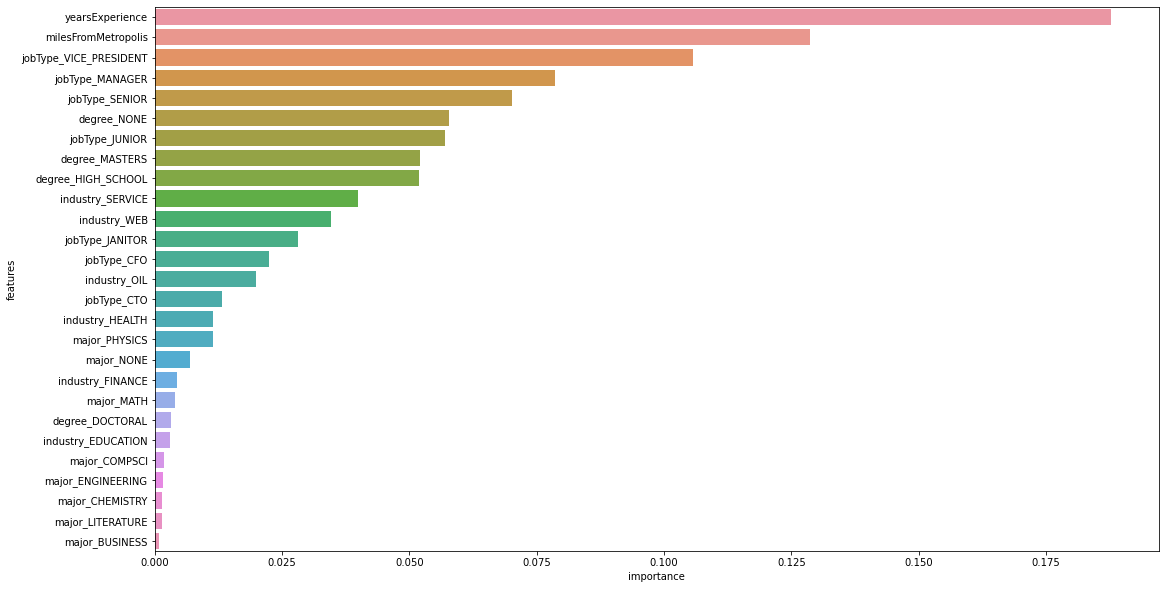

In [50]:
plt.figure(figsize=(18,10))
sns.barplot(x='importance', y='features', data=feature_importance)
plt.show();